In [1]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
%matplotlib inline
%precision 4
plt.style.use('ggplot')

## Data simulation

In [2]:
%%file SimData.py
import os
import numpy as np
import pandas as pd
import random
random.seed(42)
#Data simulation - mixture of 3 binary normal distribution
##distribution mean & covariance
mean1 = np.array([3,5])
mean2 = np.array([-2,3])
mean3 = np.array([-6,-1])
cov1 = np.array([[1,0],[0,2]])
cov2 = np.array([[1,-0.6],[-0.6,1]])
cov3 = np.array([[3,0.3],[0.3,1]])

n = 2000
N = 3*n
data = np.vstack((np.random.multivariate_normal(mean1, cov1,n),np.random.multivariate_normal(mean2, cov2,n),
                  np.random.multivariate_normal(mean3, cov3,n)))
data = data[np.random.choice(range(N),size = N, replace=False),]
df = pd.DataFrame(data,columns=["X","Y"])
df.index = pd.Index(range(N))

#Save simluated data as csv file
df.to_csv('SimData.csv', index=False)

Overwriting SimData.py


In [3]:
df = pd.read_csv('SimData.csv')
data = np.asarray(df)
#number of cluster
k = 3

## K-means++

In [4]:
%%file KMeansPlusPlus.py
from __future__ import division
import os
import numpy as np
import pandas as pd
import sklearn.cluster
# Kmeans++ function just for the convenience of benchmark and comparison of efficiency
def KmeansPlus(n_clusters_, data, n_init_=10, max_iter_=300, tol_=0.0001):
    import sklearn.cluster
    km1 = sklearn.cluster.KMeans(n_clusters = n_clusters_, init='k-means++', n_init=n_init_, max_iter=max_iter_, tol=tol_);
    km1.fit(data);
    return km1


Overwriting KMeansPlusPlus.py


/home/bitnami/anaconda/envs/python3/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


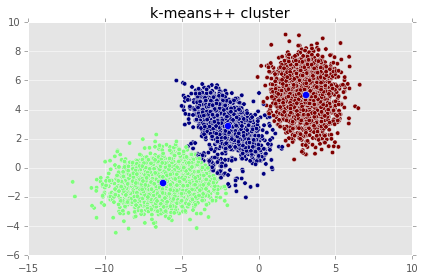

In [5]:
from KMeansPlusPlus import KmeansPlus
km1 = KmeansPlus(n_clusters_=k, data=data, n_init_=10, max_iter_=300, tol_=0.0001);
plt.figure(tight_layout=True);
plt.scatter(df.X,df.Y,c=km1.labels_);
plt.scatter(km1.cluster_centers_[:,0],km1.cluster_centers_[:,1],marker='o',s=50);
plt.title("k-means++ cluster");
plt.savefig('K-meansPlusPlus.png');

## K-means||

In [6]:
%%file KMeansParallel.py
from __future__ import division
import os
import numpy as np
import pandas as pd
import sklearn.cluster
##distance square function - we don't need the square root so we can save computation time
# euclidean distance
def dist_sq(a, b, axis = 0):
    return np.sum((a-b)**2,axis)

##cost function
# Version 1 - 2 list comprehension, no broadcasting
# def cost(c,data):
#     return np.sum([min([euclidean(d,s) for s in c])**2 for d in data])

# Version 2 - 1 list comprehension and one broadcasting
def cost(c,data):
    return np.sum([min(dist_sq(c, d, axis = 1)) for d in data])

#sampling probability function
# Version 1 - 2 list comprehension, no broadcasting
# def smpl_prb(c,data,l):
#     phi_temp = cost(c,data)
#     return np.array([(min([euclidean(d,s) for s in c])**2)*l/phi_temp for d in data])

# Version 2 - 1 list comprehension, 1 broadcasting
def smpl_prb(c,data,l):
    phi_temp = cost(c,data)
    return np.array([(min(dist_sq(c, d, axis = 1)))*l/phi_temp for d in data])


#weight function - propotional to the number of data points have the same specific center
def weight_func(c, data):
    # Find the closet point in c for each point in data
    # Version 1 - 2 list comprehension, no broadcasting
    # min_c = [np.argmin([euclidean(d,s) for s in c]) for d in data];
    # Version 2 - 1 list comprehension, 1 broadcasting
    min_c = [np.argmin(dist_sq(c, d, axis = 1)) for d in data];
    ## number of points which is closest to each s in c
    num_closest = np.array([min_c.count(i) for i in range(len(c))]).astype(float);
    ## return normalized weight
    return num_closest/np.sum(num_closest)


#Kmeans||
#l is oversampling factor

def KmeansParallel(n_clusters, data, l):
    if n_clusters <= 0 or not(isinstance(n_clusters,int)):
        sys.exit("n_cluster is not positive integer")
    
    if l <= 0: 
        sys.exit("l is not positive")
    
    if len(data) < n_clusters: 
        sys.exit("number of data is less than n_clusters")
    
    num = len(data)
    
    #Step 1 - uniformly sample one point
    c = np.array(data[np.random.choice(range(num),1),])
    
    #Step 2 - cost
    phi = cost(c,data)
    
    #Step 3~6 - get potential centers
    for i in range(np.ceil(np.log(phi)).astype(int)):
        c_add = data[smpl_prb(c,data,l)>np.random.uniform(size = num),]
        c = np.concatenate((c,c_add))
        
    #Step 7
    # Find the closet point in c for each point in data
    ##weight
    weight = weight_func(c, data)
    
    #Step 8 - recluster by kmeans++ initialization
    c_final = data[np.random.choice(range(len(c)),size=1,p=weight),]
    data_final = c
    for i in range(n_clusters-1):
        new_prb = smpl_prb(c_final,data_final,l) * weight
        c_fin_add = data[np.random.choice(range(len(c)),size=1,p=new_prb/np.sum(new_prb)),]
        c_final = np.concatenate((c_final,c_fin_add))
    
    #Do k-means with initial centers
    import sklearn.cluster
    km2 = sklearn.cluster.KMeans(n_clusters=n_clusters, n_init=1, init=c_final, max_iter=500, tol=0.0001)
    km2.fit(data);
    
    #return a KMeans type result - including: cluster_centers_, labels_, inertia_
    return km2
    

Overwriting KMeansParallel.py


/home/bitnami/anaconda/envs/python3/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


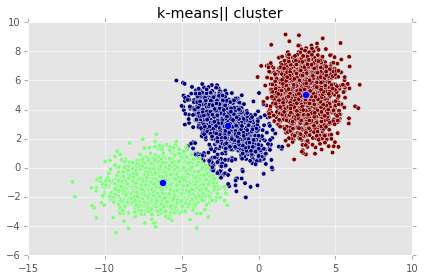

In [7]:

from KMeansParallel import KmeansParallel
km = KmeansParallel(n_clusters = k, data = data, l = 2*k);
plt.figure(tight_layout=True);
plt.scatter(df.X,df.Y,c=km.labels_);
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],marker='o',s=50);
plt.title("k-means|| cluster");
plt.savefig('K-meansParallel.png');

## Initial code profile

k-means|| is a parallel version for initializing the centers of k-means clustering method. This algorithm is somehow intuitively similar to k-means++ while the main difference is the usage of an oversampling factor $l = \Omega(k)$, some linear function of $k$.
In the first step, we sample a point $C$ uniformly at random from data set as an initial center and compute the cost of this clustering center $\psi = \phi_X(C)$, where
\begin{equation}
\phi_X(C) = \sum_{x\in X} d^2(x,C) = \sum_{x\in X} min_{c_i \in C} ||x-c_i||^2
\end{equation}
Then we run a log$\varphi$ iterations for loop, where in each iteration, we samples each point $x$ in data set $X$ with probability $\frac{ld^2(x, C)}{\phi_X(C)}$, given current cluster center set $C$. 
We update $C$ with adding the sampled points and update the cluster cost quantity $\phi_X(C)$. Then we run next iteration until the for loop is completed. 
According to the sampling probability of each data points in each iteration in for loop, the expected number of points sampled in each iteration is $l$. Thus, finally the expected number of points we sampled is $l$log$\psi$, which is expected to be more than k. 
Therefore we have to reduce the number of centers and we assigns weights to the points in $C$ according to number of points in data set $X$ which the center are closer to them than any other centers.
\begin{equation}
\omega(c_i) =  \frac{\sum_{x\in X} 1_{(d^2(x,c_i) < d^2(x,C/\{c_i\}))}}{|X|}
\end{equation}

With the weight, we can reclusters these potential cluster centers to obtain k centers. In this step we combine the idea of k-means ++ with weight we obtain in last step. In other words, we sample k cluster centers by means of k-means ++ initialization method but we combine weight and distance when we compute the cost of the cluster centers. Firstly, we sample a center, $C_{final}$, from $C$ randomly with probability as weight $\vec{\omega}$. 
Then we run a $k-1$ iteration for loop, to obtain the rest of cluster centers, where in each iteration, we samples each point $c_i$ in set $C$ with probability $\frac{d^2(c_i, C)\omega(c_i)}{\phi_C(C_{final})}$, given current cluster center set $C$. 
We update $C_{final}$ with adding the sampled points and update the cluster cost quantity $\phi_C(C_{final})$. Then we run next iteration until the for loop is completed. 
\begin{equation}
\phi_C(C_{final}) = \sum_{c_i\in C} d^2(c_i,C_{final}) \omega(c_i)
\end{equation}
where $C_{final}$ is the final cluster center set.

Notice that the size of C is significantly smaller than the input size which means the reclustering can be done quickly. 


## C version code

In [8]:
%load_ext Cython

In [9]:
%%cython -a

#KmeansParallel in C
import numpy as np
cimport numpy as np

##distance square function - we don't need the square root so we can save computation time
# Version 2 - euclidean distance in C
def dist_sq_C(a, b, axis = 0):
    return np.sum((a-b)**2,axis)

##cost function
# Version 3 - 1 list comprehension and one broadcasting in C
def cost_C(c,data):
    return np.sum([min(dist_sq_C(c, d, axis = 1)) for d in data])

#sampling probability function
# Version 3 - 1 list comprehension, 1 broadcasting in C
def smpl_prb_C(c,data,l):
    phi_temp = cost_C(c,data)
    return np.array([(min(dist_sq_C(c, d, axis = 1)))*l/phi_temp for d in data])

##weight function - propotional to the number of data points have the same specific center
# Version 3 - C
def weight_func_C(c, data):
    # Find the closet point in c for each point in data
    min_c = [np.argmin(dist_sq_C(c, d, axis = 1)) for d in data];
    ## number of points which is closest to each s in c
    num_closest = np.array([min_c.count(i) for i in range(len(c))]).astype(float);
    ## return normalized weight
    return num_closest/np.sum(num_closest)


#Kmeans||
#l is oversampling factor
# Kmeans parallel initialization in C
def KmeansParallel_Init_C(n_clusters, data, l):
    
    num = len(data)
    
    #Step 1 - uniformly sample one point
    c = np.array(data[np.random.choice(range(num),1),])
    
    #Step 2 - cost
    phi = cost_C(c,data)
    
    #Step 3~6 - get potential centers
    for i in range(np.ceil(np.log(phi)).astype(int)):
        c_add = data[smpl_prb_C(c,data,l)>np.random.uniform(size = num),]
        c = np.concatenate((c,c_add))
        
    #Step 7
    # Find the closet point in c for each point in data
    ##weight
    weight = weight_func_C(c,data)
    
    #Step 8 - recluster by kmeans++ initialization
    c_final = data[np.random.choice(range(len(c)),size=1,p=weight),]
    data_final = c
    for i in range(n_clusters-1):
        new_prb = smpl_prb_C(c_final,data_final,l) * weight
        c_fin_add = data[np.random.choice(range(len(c)),size=1,p=new_prb/np.sum(new_prb)),]
        c_final = np.concatenate((c_final,c_fin_add))
    
    #return a KMeans type result - including: cluster_centers_, labels_, inertia_
    return c_final
    


In [10]:
c_final_C = KmeansParallel_Init_C(n_clusters = k, data = data, l = 2*k)
import sklearn.cluster
kmC = sklearn.cluster.KMeans(n_clusters=k, n_init=1, init=c_final_C, max_iter=500, tol=0.0001)
kmC.fit(data);

/home/bitnami/anaconda/envs/python3/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


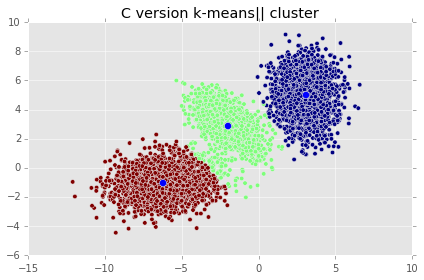

In [11]:
plt.figure(tight_layout=True);
plt.scatter(df.X,df.Y,c=kmC.labels_);
plt.scatter(kmC.cluster_centers_[:,0],kmC.cluster_centers_[:,1],marker='o',s=50);
plt.title("C version k-means|| cluster");
plt.savefig('K-meansParallel_C.png');

## Parallelized code with multiple cores

In [12]:
%%file KMeansParallel_MC.py
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from multiprocessing import Pool, cpu_count
from functools import partial

##distance square function - we don't need the square root so we can save computation time
# euclidean distance
def dist_sq(a, b, axis = 0):
    return np.sum((a-b)**2,axis)

##minimum distance square between data and centers
def min_dist_sq(d, c, axis):
    return np.min(dist_sq(c,d,axis))

##cost function
# Version 4 - parallel computing with multiple cores
def cost_mc(c,data,axis=1):
    pool = Pool(processes=cpu_count())
    # define a partial function for min_dist_sq
    partial_min_dist_sq = partial(min_dist_sq, c=c, axis=1)
    cost = np.sum(pool.map(partial_min_dist_sq, data))
    pool.close()
    pool.terminate()
    return cost


#sampling probability function
# Version 4 - parallel computing with multiple cores
def smpl_prb_mc(c,data,l,axis):
    phi_temp = cost_mc(c,data,axis)
    pool = Pool(processes=cpu_count())
    # define a partial function for min_dist_sq
    partial_min_dist_sq2 = partial(min_dist_sq, c=c, axis=1)
    sampling_prob = np.array(pool.map(partial_min_dist_sq2, data))*l/phi_temp
    pool.close()
    pool.terminate()
    return sampling_prob

##weight function 
# propotional to the number of data points have the same specific center
# Version 2
def weight_func(c, data):
    # Find the closet point in c for each point in data
    min_c = [np.argmin(dist_sq(c, d, axis = 1)) for d in data];
    ## number of points which is closest to each s in c
    num_closest = np.array([min_c.count(i) for i in range(len(c))]).astype(float);
    ## return normalized weight
    return num_closest/np.sum(num_closest)


#Kmeans||
#l is oversampling factor

def KmeansParallel_mc(n_clusters, data, l):
    if n_clusters <= 0 or not(isinstance(n_clusters,int)):
        sys.exit("n_cluster is not positive integer")
    
    if l <= 0: 
        sys.exit("l is not positive")
    
    if len(data) < n_clusters: 
        sys.exit("number of data is less than n_clusters")
    
    num = len(data)
    
    #Step 1 - uniformly sample one point
    c = np.array(data[np.random.choice(range(num),1),])
    
    #Step 2 - cost
    phi = cost_mc(c,data,axis=1)
    
    #Step 3~6 - get potential centers
    for i in range(np.ceil(np.log(phi)).astype(int)):
        c_add = data[smpl_prb_mc(c,data,l,axis=1)>np.random.uniform(size = num),]
        c = np.concatenate((c,c_add))
        
    #Step 7
    # Find the closet point in c for each point in data
    ##weight
    weight = weight_func(c,data)
    
    #Step 8 - recluster by kmeans++ initialization
    c_final = data[np.random.choice(range(len(c)),size=1,p=weight),]
    data_final = c
    for i in range(n_clusters-1):
        new_prb = smpl_prb_mc(c_final,data_final,l,axis=1) * weight
        c_fin_add = data[np.random.choice(range(len(c)),size=1,p=new_prb/np.sum(new_prb)),]
        c_final = np.concatenate((c_final,c_fin_add))
    
    
    #Do k-means with initial centers
    import sklearn.cluster
    km2 = sklearn.cluster.KMeans(n_clusters=n_clusters, n_init=1, init=c_final, max_iter=500, tol=0.0001)
    km2.fit(data);
    
    #return a KMeans type result - including: cluster_centers_, labels_, inertia_
    return km2
    

Overwriting KMeansParallel_MC.py


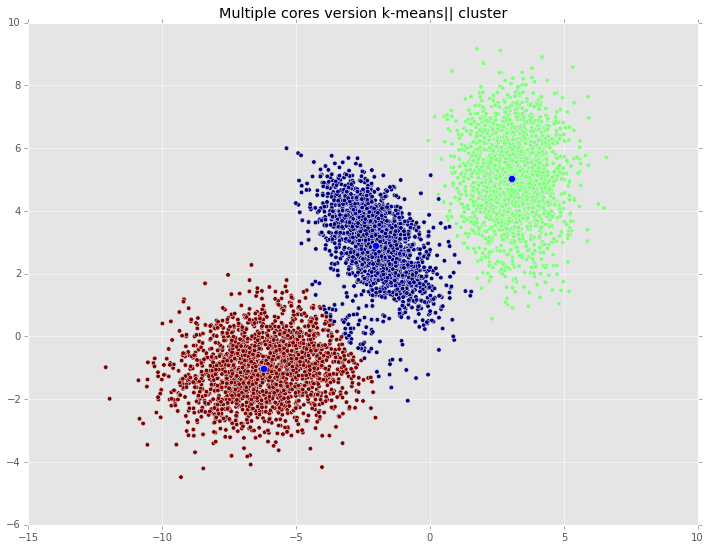

In [13]:
from KMeansParallel_MC import KmeansParallel_mc
km_mc = KmeansParallel_mc(n_clusters = k, data = data, l = 2*k);
plt.figure(figsize=(12, 9));
plt.scatter(df.X,df.Y,c=km_mc.labels_);
plt.scatter(km_mc.cluster_centers_[:,0],km_mc.cluster_centers_[:,1],marker='o',s=50);
plt.title("Multiple cores version k-means|| cluster");
plt.savefig('K-meansParallel_MC.png');

## Efficiency Comparison

In [14]:
%timeit -n 10 KmeansPlus(n_clusters_=k, data=data, n_init_=10, max_iter_=300, tol_=0.0001);
%timeit -n 10 KmeansParallel(n_clusters = k, data = data, l = 2*k);
%timeit -n 10 KmeansParallel_mc(n_clusters = k, data = data, l = 2*k);
%timeit -n 10 KmeansParallel_Init_C(n_clusters = k, data = data, l = 2*k);

10 loops, best of 3: 32.9 ms per loop
10 loops, best of 3: 3.76 s per loop
10 loops, best of 3: 6.16 s per loop
10 loops, best of 3: 3.59 s per loop


In [18]:
%%file prepare_result.py
from __future__ import division
import os
import sys
import glob
from tabulate import tabulate
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
plt.style.use('ggplot')
df = pd.read_csv('SimData.csv')
data = np.array(df)
#number of cluster
k = 3

with open('table.tex', 'w') as f:
    f.write(tabulate(df.ix[:10,], headers=list(df.columns),tablefmt="latex", floatfmt=".4f"))

from KMeansPlusPlus import KmeansPlus
km1 = KmeansPlus(n_clusters_=k, data=data, n_init_=10, max_iter_=300, tol_=0.0001);
plt.figure(tight_layout=True);
plt.scatter(df.X,df.Y,c=km1.labels_);
plt.scatter(km1.cluster_centers_[:,0],km1.cluster_centers_[:,1],marker='o',s=50);
plt.title("k-means++ cluster");
plt.savefig('K-meansPlusPlus.png');

from KMeansParallel import KmeansParallel
km = KmeansParallel(n_clusters = k, data = data, l = 2*k);
# plt.figure(figsize=(12, 9));
plt.figure(tight_layout=True);
plt.scatter(df.X,df.Y,c=km.labels_);
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],marker='o',s=50);
plt.title("k-means|| cluster");
plt.savefig('K-meansParallel.png');

from KMeansParallel_MC import KmeansParallel_mc
km_mc = KmeansParallel_mc(n_clusters = k, data = data, l = 2*k);
# plt.figure(figsize=(12, 9));
plt.figure(tight_layout=True);
plt.scatter(df.X,df.Y,c=km_mc.labels_);
plt.scatter(km_mc.cluster_centers_[:,0],km_mc.cluster_centers_[:,1],marker='o',s=50);
plt.title("Multiple cores version k-means|| cluster");
plt.savefig('K-meansParallel_MC.png');

Overwriting prepare_result.py


In [20]:
! python prepare_result.py